In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/manojaryalgit/nepal-earthquake-mb-data/refs/heads/main/mbEQDatabyManoj.csv')

# Convert 'Date and Time' to datetime
df['Date and Time'] = pd.to_datetime(df['Date and Time'], format='%Y/%m/%d %H:%M:%S')

df = df.sort_values('Date and Time')

# Create new features
df['Days_Since_Last'] = df['Date and Time'].diff().dt.total_seconds() / (24 * 60 * 60)
df['Day_of_Year'] = df['Date and Time'].dt.dayofyear
df['Month'] = df['Date and Time'].dt.month

# Create rolling mean of past 5 events
df['MAG_Rolling_Mean'] = df['MAG'].rolling(window=5).mean()

# Convert columns to numeric, replacing empty strings with NaN
numeric_columns = ['LAT', 'LON', 'DEPTH', 'MAG']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Prepare features and target
features = ['LAT', 'LON', 'DEPTH', 'Days_Since_Last', 'Day_of_Year', 'Month', 'MAG_Rolling_Mean']
target = 'MAG'

X = df[features]
y = df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (before transforming to NumPy array)
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you have the test indices in X_test_df
test_indices = X_test_df.index

# Convert features to NumPy arrays after splitting
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Retrieve the 'Date and Time' column for the test data using the test_indices
dates = df.loc[test_indices, "Date and Time"]

print("Data preprocessing completed.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Data preprocessing completed.
Training set shape: (2345, 1, 7)
Test set shape: (587, 1, 7)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    LSTM(64, input_shape=(1, X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("Model training completed.")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 13.7971 - val_loss: 3.2593
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6886 - val_loss: 0.6586
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6672 - val_loss: 0.5129
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5161 - val_loss: 0.4086
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4567 - val_loss: 0.3275
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3732 - val_loss: 0.2731
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3281 - val_loss: 0.2356
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3006 - val_loss: 0.2050
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2544 - val_loss: 0.1862
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2486 - val_loss: 0.1743
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2161 - val_loss: 0.1650
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2142 - val_l

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


<ipython-input-3-44dcee8c2a69>:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()


Mean Absolute Error: 0.2751831265893056
Root Mean Square Error: 0.38011087134213584
R-squared Score: 0.4159123771869503


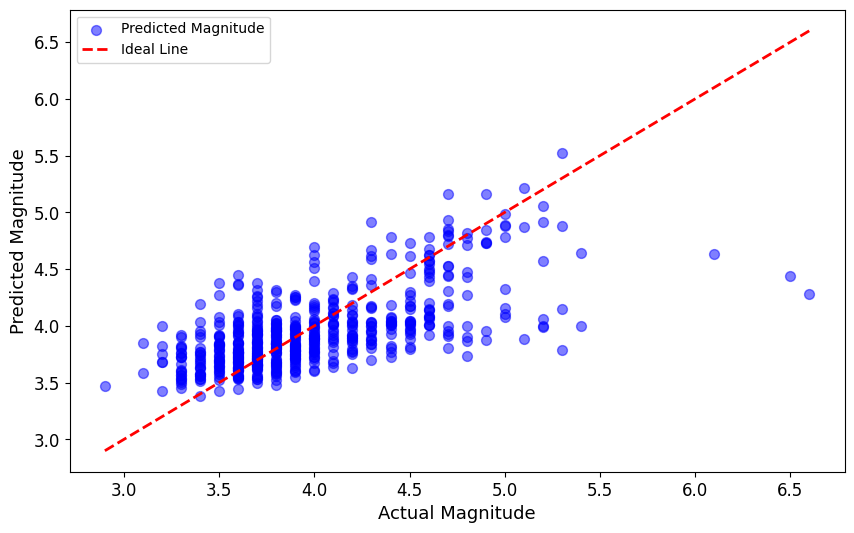

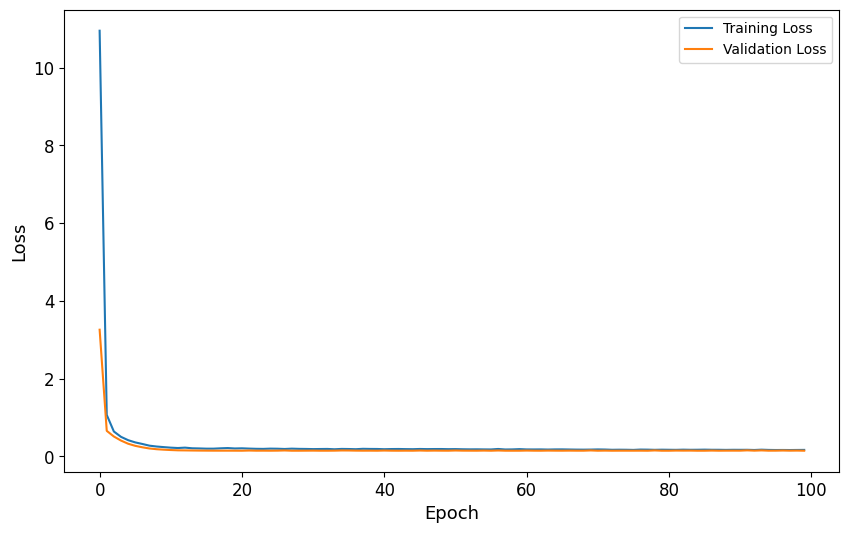

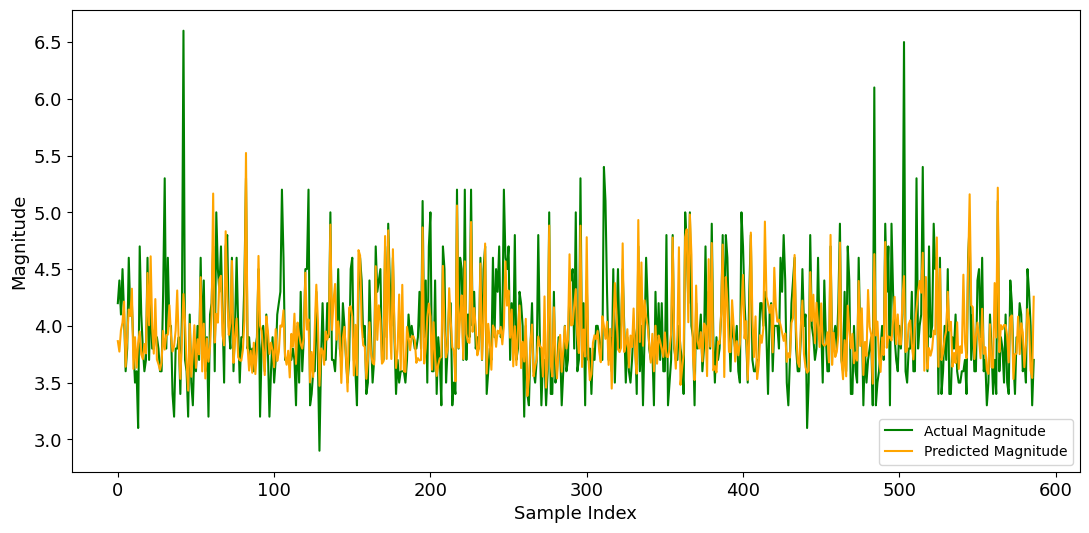

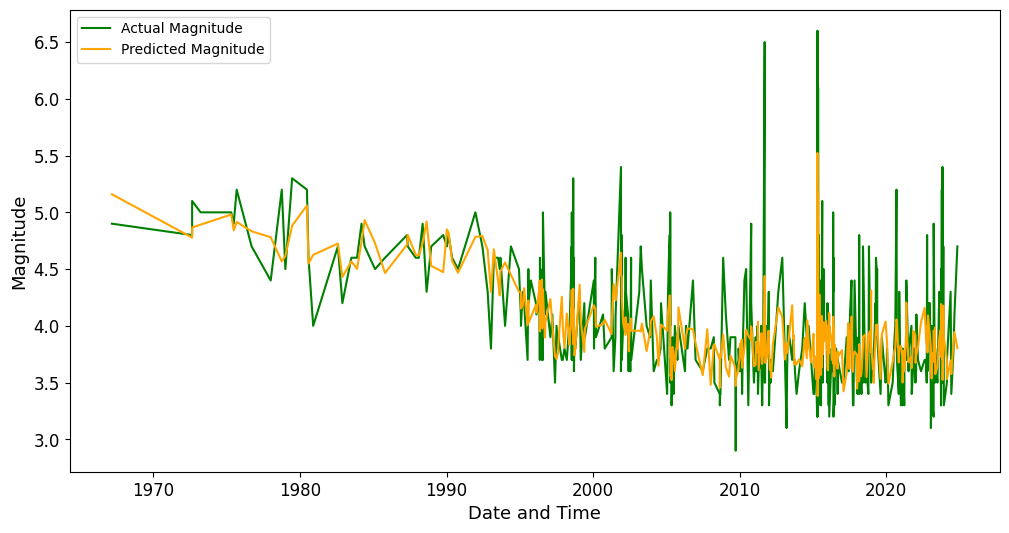

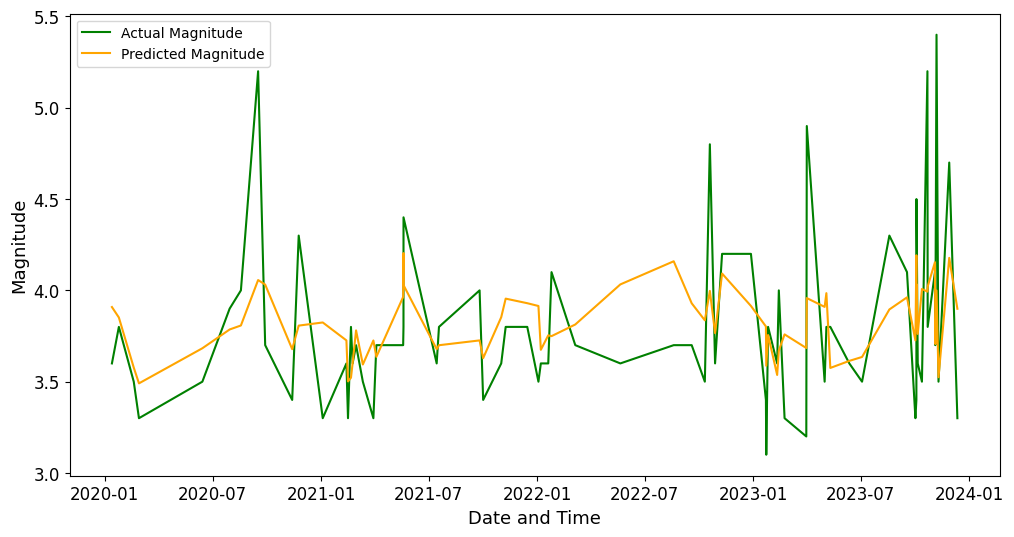

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Make predictions
y_pred = model.predict(X_test).ravel()
y_test = y_test.ravel()

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Square Error: {rmse}")
print(f"R-squared Score: {r2}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label='Predicted Magnitude', color='blue', alpha=0.5, s=50)  # alpha for transparency, s for size
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
plt.xlabel('Actual Magnitude', fontsize=13, fontweight='medium')
plt.ylabel('Predicted Magnitude', fontsize=13, fontweight='medium')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss', fontsize=13, fontweight='medium')
plt.xlabel('Epoch', fontsize=13, fontweight='medium')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

# Plot Actual vs Predicted Line Graph
plt.figure(figsize=(13, 6))
plt.plot(y_test, label='Actual Magnitude', color='green')
plt.plot(y_pred, label='Predicted Magnitude', color='orange')
plt.xlabel('Sample Index', fontsize=13, fontweight='medium')
plt.ylabel('Magnitude', fontsize=13, fontweight='medium')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.show()


# Sort dates and corresponding actual/predicted values by date
sorted_indices = np.argsort(dates)
sorted_dates = dates.iloc[sorted_indices]
sorted_y_test = np.array(y_test)[sorted_indices]
sorted_y_pred = y_pred[sorted_indices]


# Plot Actual vs Predicted Line Graph with properly sorted 'Date and Time'
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, sorted_y_test, label='Actual Magnitude', color='green')
plt.plot(sorted_dates, sorted_y_pred, label='Predicted Magnitude', color='orange')
plt.xlabel('Date and Time', fontsize=13, fontweight='medium')
plt.ylabel('Magnitude', fontsize=13, fontweight='medium')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()



# Filter dates between 2020 and 2025
mask = (sorted_dates >= '2020-01-01') & (sorted_dates <= '2024-01-30')

# Apply the mask to filter data
filtered_dates = sorted_dates[mask]
filtered_y_test = sorted_y_test[mask]
filtered_y_pred = sorted_y_pred[mask]

# Plot Actual vs Predicted Line Graph for 2020 to 2025
plt.figure(figsize=(12, 6))
plt.plot(filtered_dates, filtered_y_test, label='Actual Magnitude', color='green')
plt.plot(filtered_dates, filtered_y_pred, label='Predicted Magnitude', color='orange')
# Make the X and Y labels bold and larger
plt.xlabel('Date and Time', fontsize=13, fontweight='medium')
plt.ylabel('Magnitude', fontsize=13, fontweight='medium')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

In [4]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Ensure X_scaled and y are numpy arrays
X_scaled = X_scaled.to_numpy() if isinstance(X_scaled, pd.DataFrame) else X_scaled
y = y.to_numpy() if isinstance(y, pd.Series) else y

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled)):
    print(f"Fold {fold + 1}/{n_splits}")

    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    model_clone = clone_model(model)
    model_clone.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model_clone.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_pred = model_clone.predict(X_val)

    mae_scores.append(mean_absolute_error(y_val, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    r2_scores.append(r2_score(y_val, y_pred))

print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

Fold 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Average MAE: 0.29728071756247193
Average RMSE: 0.39415249450429285
Average R-squared: 0.430303841183682


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,637 (240.77 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,092 (160.52 KB)